In [5]:
!pip install pydub librosa
!apt-get install -y libasound-dev portaudio19-dev libportaudio2 libportaudiocpp0
!pip install pyaudio
!apt-get install -y libportaudio2
!pip install sounddevice
!pip install sounddevice numpy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libasound2-dev' instead of 'libasound-dev'
libasound2-dev is already the newest version (1.2.6.1-1ubuntu1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 0s (624 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 121654 files and directories currently installed.)
Preparin

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import librosa
import librosa.display
import numpy as np

# Load the Google Speech Commands Dataset
dataset_name = "speech_commands"
ds_info = tfds.builder(dataset_name).info


dataset = tfds.load(dataset_name, split='train')

# Split the dataset into training, validation, and test sets
split_percentages = [80, 10, 10]
num_examples = len(dataset)
train_size = int((split_percentages[0] / 100) * num_examples)
validation_size = int((split_percentages[1] / 100) * num_examples)

train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
validation_dataset = remaining_dataset.take(validation_size)
test_dataset = remaining_dataset.skip(validation_size)


def preprocess(example):
    waveform = example["audio"]
    label = example["label"]

    # Convert the waveform to floating point
    waveform = tf.cast(waveform, tf.float32)

    # Compute mel spectrogram
    mel_spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128, fft_length=256)
    mel_spectrogram = tf.abs(mel_spectrogram)
    mel_spectrogram = tf.square(mel_spectrogram)

    # Convert to mel scale
    num_mel_bins = 128
    mel_filters = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, 129, 16000, 0.0, 8000.0)
    mel_spectrogram = tf.matmul(mel_spectrogram, mel_filters)

    # Logarithmic compression
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # Normalize to have zero mean and unit variance
    mel_spectrogram = tf.image.per_image_standardization(tf.expand_dims(mel_spectrogram, axis=-1))

    # Reshape to match the model input shape
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)

    return mel_spectrogram, label

##updated preprocess
def preprocess(example):
    waveform = example["audio"]
    label = example["label"]

    # Convert the waveform to floating point
    waveform = tf.cast(waveform, tf.float32)

    # Compute mel spectrogram
    mel_spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128, fft_length=256)
    mel_spectrogram = tf.abs(mel_spectrogram)
    mel_spectrogram = tf.square(mel_spectrogram)

    # Convert to mel scale
    num_mel_bins = 128
    mel_filters = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, 129, 16000, 0.0, 8000.0)
    mel_spectrogram = tf.matmul(mel_spectrogram, mel_filters)

    # Logarithmic compression
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # Normalize to have zero mean and unit variance
    mel_spectrogram = tf.image.per_image_standardization(tf.expand_dims(mel_spectrogram, axis=-1))

    return tf.image.resize(mel_spectrogram, (124, 128)), label


# Apply the preprocessing to the datasets
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/85511 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/0.0.3.incompleteCFYSQT/speech_commands-train.tfrecord*...:…

Generating validation examples...:   0%|          | 0/10102 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/0.0.3.incompleteCFYSQT/speech_commands-validation.tfrecord…

Generating test examples...:   0%|          | 0/4890 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/0.0.3.incompleteCFYSQT/speech_commands-test.tfrecord*...: …

Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.


In [7]:
len(dataset)

85511

In [8]:
for mel_spectrogram, label in train_dataset.take(1):  # Take one batch for inspection
    print("Spectrogram shape:", mel_spectrogram.shape)

Spectrogram shape: (124, 128, 1)


In [9]:
for data in train_dataset.take(1):  # Take one batch for inspection
    audio_data, label = data
    print("Spectrogram shape:", audio_data.shape)


Spectrogram shape: (124, 128, 1)


Sample 1, Label: 4, Audio Shape: (124, 128)


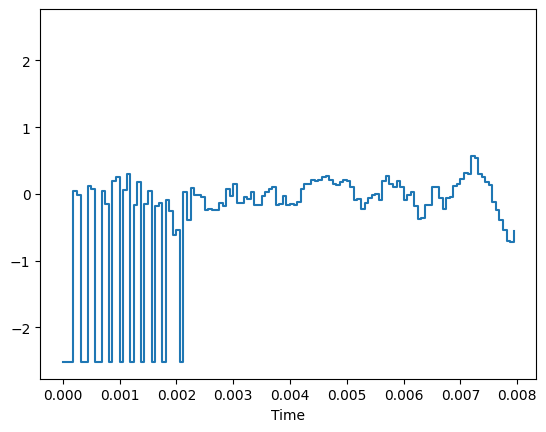

Sample 2, Label: 5, Audio Shape: (124, 128)


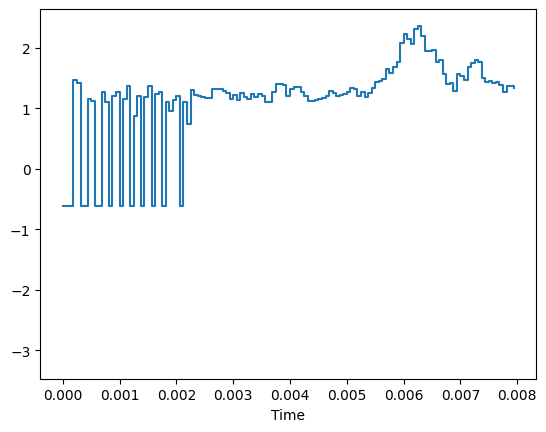

Sample 3, Label: 7, Audio Shape: (124, 128)


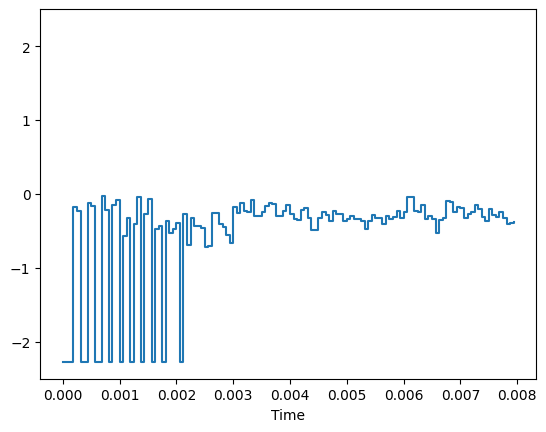

Sample 4, Label: 5, Audio Shape: (124, 128)


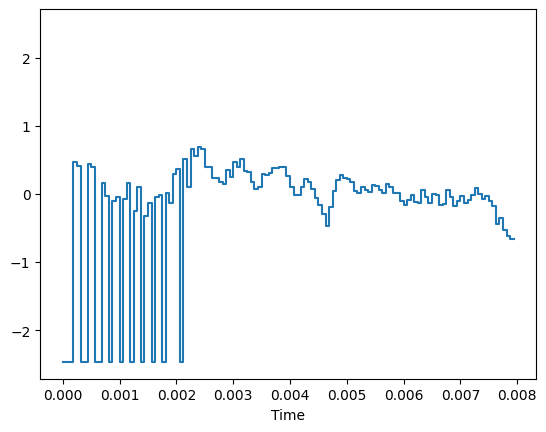

Sample 5, Label: 7, Audio Shape: (124, 128)


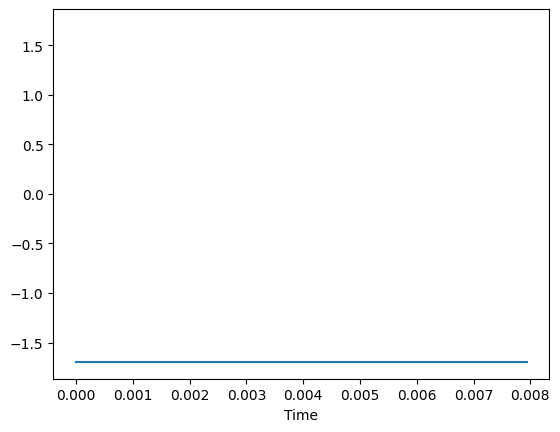

Sample 6, Label: 2, Audio Shape: (124, 128)


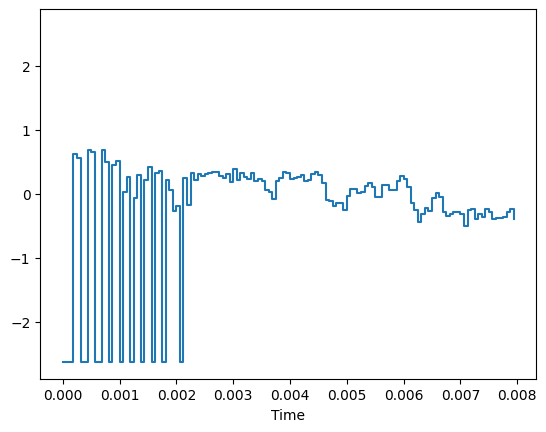

Sample 7, Label: 11, Audio Shape: (124, 128)


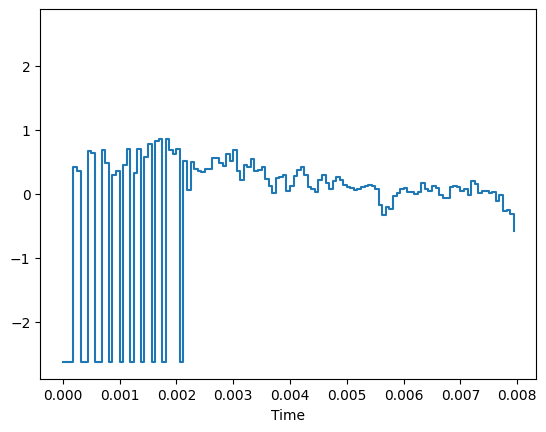

Sample 8, Label: 7, Audio Shape: (124, 128)


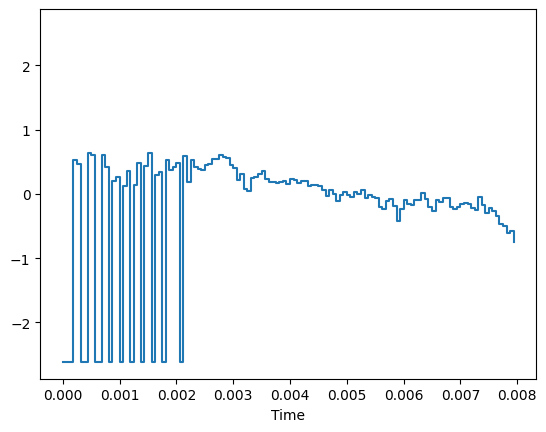

Sample 9, Label: 6, Audio Shape: (124, 128)


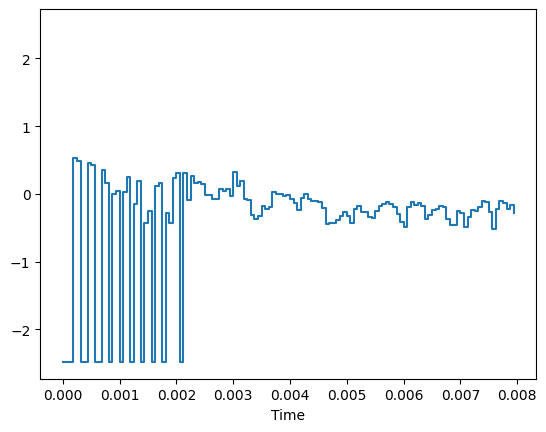

Sample 10, Label: 6, Audio Shape: (124, 128)


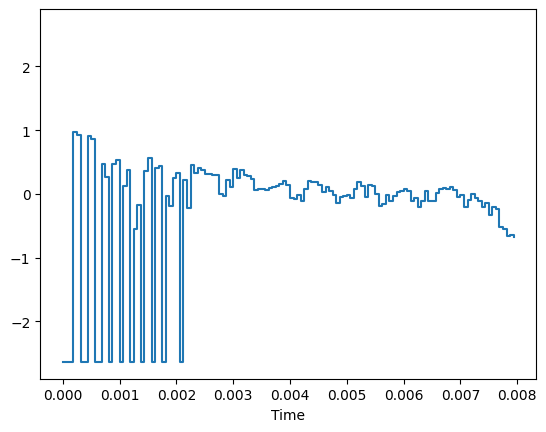

In [10]:
import librosa
import matplotlib.pyplot as plt


num_samples_to_display = 10

for i, (audio, label) in enumerate(train_dataset.take(num_samples_to_display)):
    sample_audio = audio.numpy().squeeze()
    sample_rate = 16000  # Assuming a sample rate of 16kHz

    # Print the label and the shape of the audio tensor
    print(f"Sample {i + 1}, Label: {label.numpy()}, Audio Shape: {sample_audio.shape}")

    # Play the audio using librosa
    librosa.display.waveshow(sample_audio, sr=sample_rate)
    plt.show()


In [11]:
len(dataset)

85511

In [12]:
# CNN model
from tensorflow import keras

model = keras.Sequential([
    layers.Input(shape=(124, 128, 1)),  # Ensure consistent input shape
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
model.fit(train_dataset.batch(32),
          epochs=2,
          validation_data=validation_dataset.batch(32))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset.batch(32))
print(f'Test accuracy: {test_acc}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 14, 128)       0

In [13]:
import pandas as pd

# Function to collect actual and predicted labels
def collect_predictions(model, test_dataset):
    actual_labels = []
    predicted_labels = []

    for audio, label in test_dataset:
        # Reshape the audio to match the model input shape
        audio = tf.image.resize(audio, (124, 128))
        audio = tf.expand_dims(audio, axis=-1)

        # Make predictions using the model
        prediction = model.predict(tf.expand_dims(audio, axis=0))
        predicted_class = np.argmax(prediction)

        actual_labels.append(int(label.numpy()))
        predicted_labels.append(predicted_class)

    return actual_labels, predicted_labels

# Collect actual and predicted labels
actual_labels, predicted_labels = collect_predictions(model, test_dataset)

# Create a DataFrame
df = pd.DataFrame({
    'Actual_Labels': actual_labels,
    'Predicted_Labels': predicted_labels
})

# Display the DataFrame
print(df)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 72ms/step
      Actual_Labels  Predicted_Labels
0                11                11
1                11                11
2                 9                 9
3                11                11
4                 2                 2
...             ...               ...
8547              4                 4
8548             11                11
8549             11                11
8550             11                11
8551              5                 5

[8552 rows x 2 columns]


In [74]:
df[df["Actual_Labels"]!= df["Predicted_Labels"]]

,Actual_Labels,Predicted_Labels
24,11,6
41,9,11
47,6,2
63,3,11
76,11,5
...,...,...
8495,0,11
8498,2,11
8499,3,11
8507,6,11


In [ ]:
class_names

['down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'stop',
 'up',
 'yes',
 '_silence_',
 '_unknown_']

In [38]:
def preprocess(example):
    waveform = example["audio"]
    label = example["label"]

    # Convert the waveform to floating point
    waveform = tf.cast(waveform, tf.float32)

    # Compute mel spectrogram
    mel_spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128, fft_length=256)
    mel_spectrogram = tf.abs(mel_spectrogram)
    mel_spectrogram = tf.square(mel_spectrogram)

    # Convert to mel scale
    num_mel_bins = 128
    mel_filters = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, 129, 16000, 0.0, 8000.0)
    mel_spectrogram = tf.matmul(mel_spectrogram, mel_filters)

    # Logarithmic compression
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # Normalize to have zero mean and unit variance
    mel_spectrogram = tf.image.per_image_standardization(tf.expand_dims(mel_spectrogram, axis=-1))

    return tf.image.resize(mel_spectrogram, (124, 128)), label


Saving off.mp3 to off.mp3


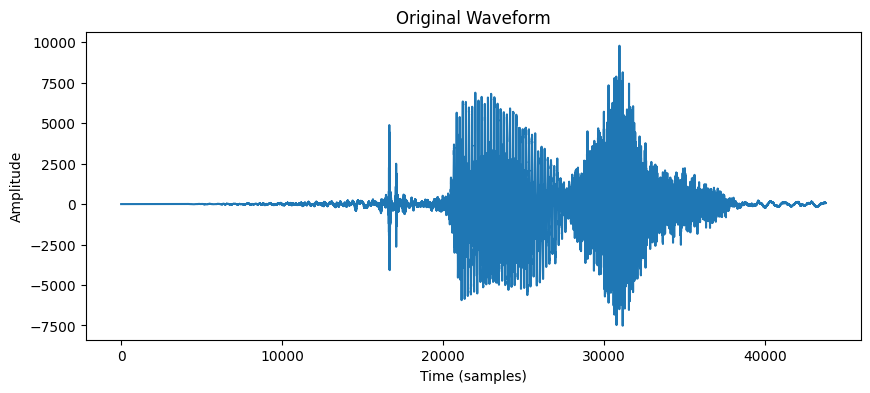

1/1 [==============================] - 0s 36ms/step
[1.6095133e-05 9.8672142e-05 9.9657290e-03 4.2029871e-05 8.4541678e-02
 1.9240796e-03 1.9777226e-04 8.7602657e-06 4.7351768e-05 1.4157134e-02
 6.3128990e-12 8.8900059e-01]
The predicted label is: off


In [60]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import io
import numpy as np
from pydub import AudioSegment

def handle_upload(change):
    uploaded_files = change['new']
    audio_data = next(iter(uploaded_files.values()))

    # Load the original audio file using pydub
    original_audio = AudioSegment.from_file(io.BytesIO(audio_data))

    # Convert pydub AudioSegment to NumPy array
    audio_np = np.array(original_audio.get_array_of_samples())

    # Visualize the waveform of the original audio
    plt.figure(figsize=(10, 4))
    plt.plot(audio_np)
    plt.title('Original Waveform')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

    # Play the original audio
    display(Audio(data=audio_np, rate=original_audio.frame_rate))

    # Convert the uploaded audio file to the required format for prediction
    processed_audio, _ = preprocess({"audio": audio_np, "label": None})
    processed_audio = tf.image.resize(processed_audio, (124, 128))
    processed_audio = tf.expand_dims(processed_audio, axis=-1)

    # Play the preprocessed audio
    display(Audio(data=processed_audio.numpy().squeeze(), rate=16000))

    # Make predictions using the loaded model
    prediction = model.predict(tf.expand_dims(processed_audio, axis=0)).flatten()

    print(prediction)
    predicted_class = np.argmax(prediction)
    labels = ['down','go','left','no','off','on','right','stop','up','yes','_silence_','_unknown_']
    predicted_label=""
    if labels[predicted_class] == "_unknown_":
    # Get the second highest predicted class index
      second_highest_index = np.argsort(prediction)[-2]

    # Get the label corresponding to the second highest index
      predicted_label = labels[second_highest_index]
    else:
    # Get the label corresponding to the predicted class index
      predicted_label = labels[predicted_class]

    print(f"The predicted label is: {predicted_label}")

# Display the upload button
upload_button = files.upload()

# Handle the uploaded file directly
if upload_button:
    handle_upload({'new': upload_button})


Saving Record (online-voice-recorder.com) (8).mp3 to Record (online-voice-recorder.com) (8) (1).mp3


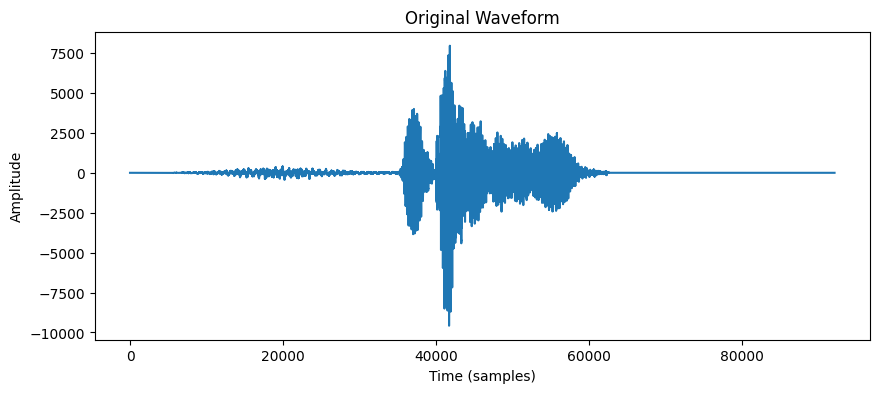

1/1 [==============================] - 0s 43ms/step
[1.3275152e-03 2.0670281e-04 1.2224064e-04 4.4196018e-05 3.3067985e-04
 1.8090253e-04 1.1064884e-05 7.6824601e-04 3.0910927e-05 7.0666531e-05
 1.5221050e-09 9.9690682e-01]
The predicted label is: down


In [61]:
upload_button = files.upload()

# Handle the uploaded file directly
if upload_button:
    handle_upload({'new': upload_button})

In [35]:

import IPython.display as ipd
for example in dataset:
    audio_data = example["audio"].numpy()

    # Play the audio sample with a default sample rate
    ipd.display(ipd.Audio(audio_data, rate=16000))  # Assuming a common sample rate of 16,000 Hz

    # Display the transcription of the speech command
    print("Transcription:", example["label"].numpy())
    break

Transcription: 4


Saving Record (online-voice-recorder.com) (5).mp3 to Record (online-voice-recorder.com) (5) (19).mp3


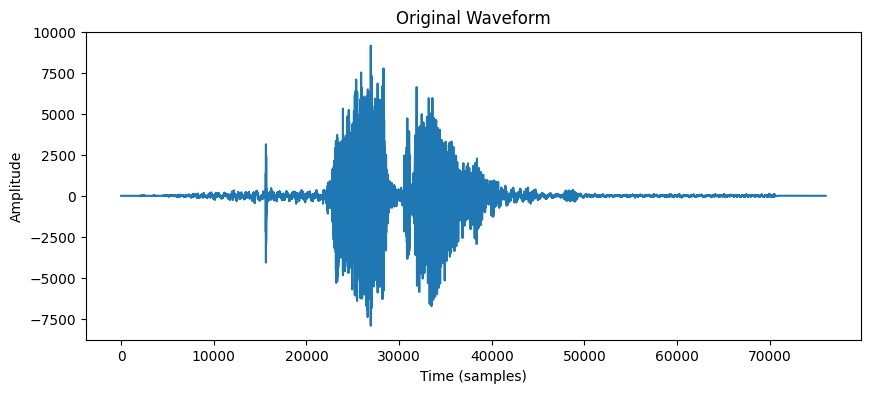

1/1 [==============================] - 0s 49ms/step
[4.32455493e-03 1.47872051e-04 2.85347235e-09 1.09307244e-07
 1.44304373e-04 4.90732840e-04 1.84807423e-08 4.89210263e-02
 1.47099514e-03 6.82497836e-10 1.17613710e-13 9.44500327e-01]
The predicted label is: stop


In [62]:
upload_button = files.upload()

# Handle the uploaded file directly
if upload_button:
    handle_upload({'new': upload_button})